In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
#importing project created functions, these can be found in model_prep folder in repo
from model_prep import Xy_prep_all, Xy_prep_silence, Xy_prep_music, cross_val_time

In [4]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:60301" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:60321, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:60324, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:60318, threads: 2>})

In [5]:
model_data = pd.read_pickle('DFs/model_data.pkl')

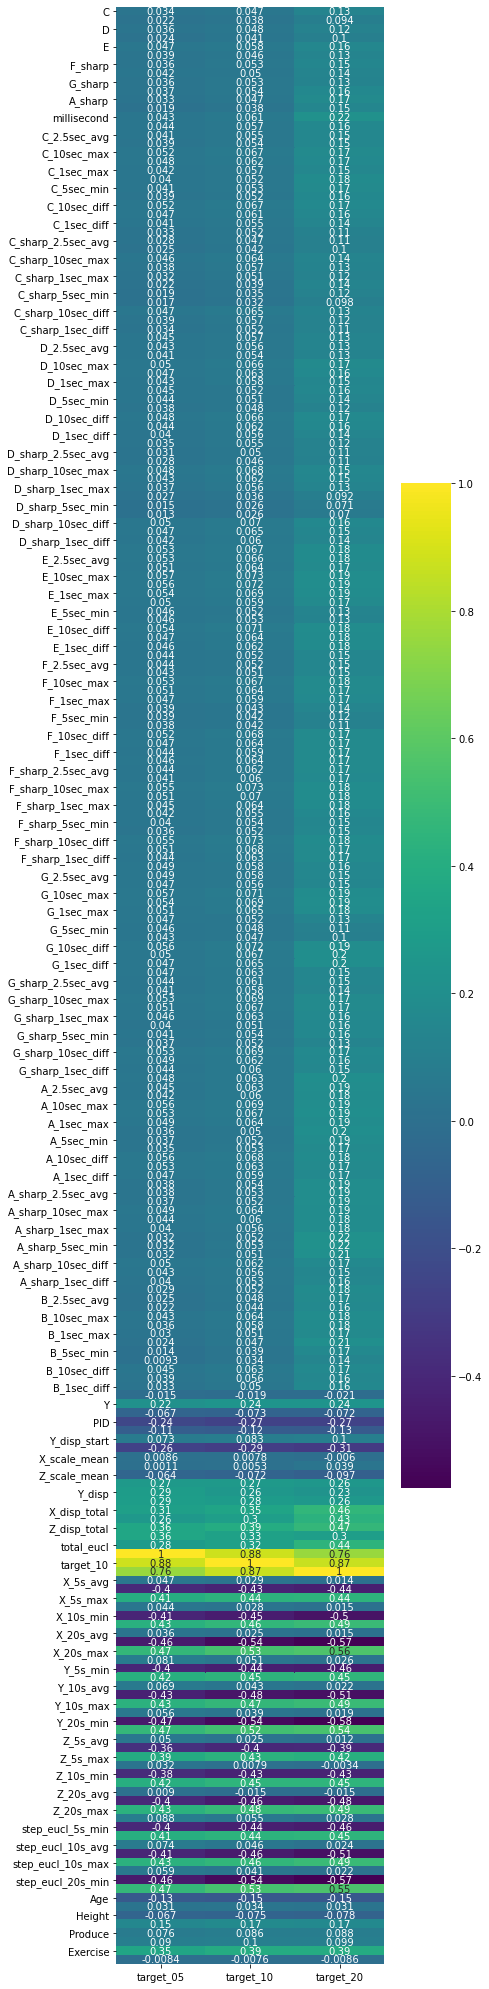

In [6]:
#Taking a look a correlations between features
corr = model_data.corr()
plt.figure(figsize=(6,36))
with joblib.parallel_backend('dask'):
    sns.heatmap(corr.loc[:,['target_05', 'target_10', 'target_20']], annot=True, cmap='viridis')
plt.savefig('correlation')
plt.show()

In [7]:
model_data['segment'].unique()

array(['silence', 'class1', 'class2', 'class3', 'class4', 'hiphop',
       'salsa', 'edm'], dtype=object)

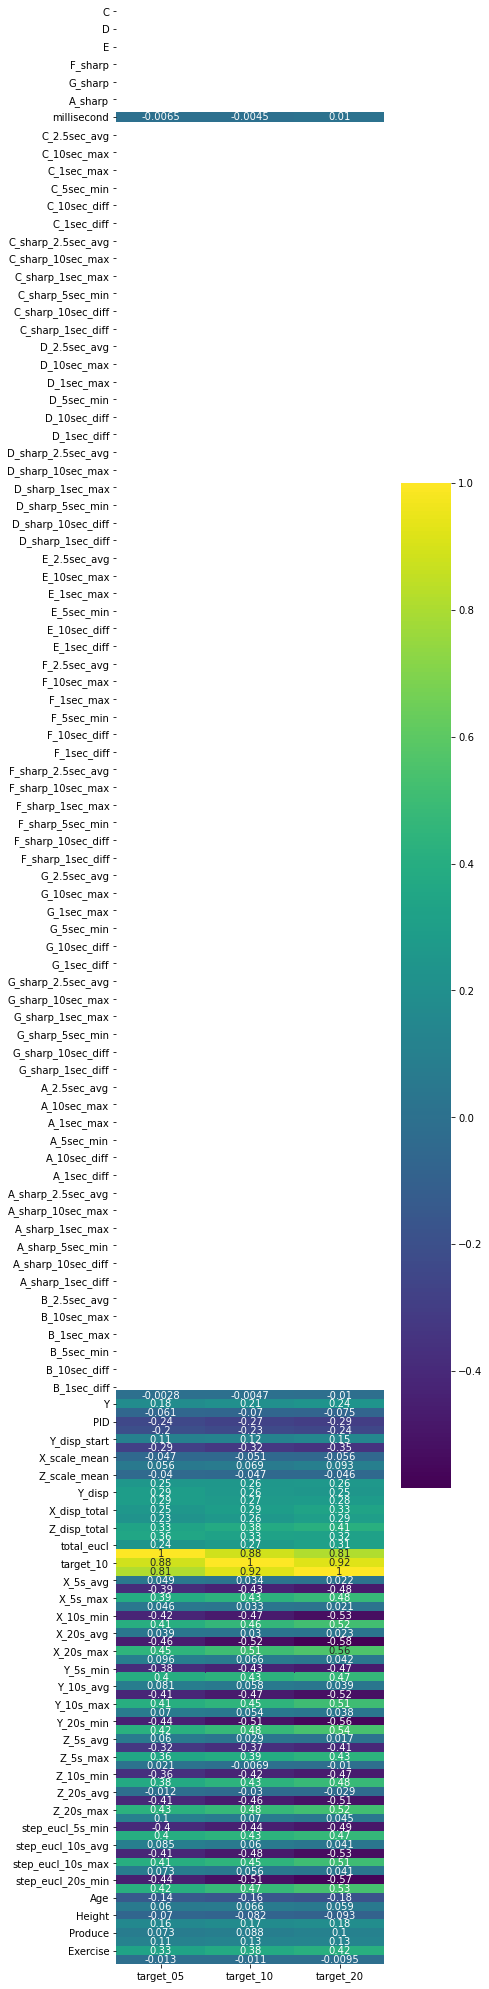

In [8]:
#Taking a look a correlations between features for silent only
silent_data = model_data.loc[model_data['segment']=='silence']
corr_sil = silent_data.corr()
plt.figure(figsize=(6,36))
with joblib.parallel_backend('dask'):
    sns.heatmap(corr_sil.loc[:,['target_05', 'target_10', 'target_20']], annot=True, cmap='viridis')
plt.show()

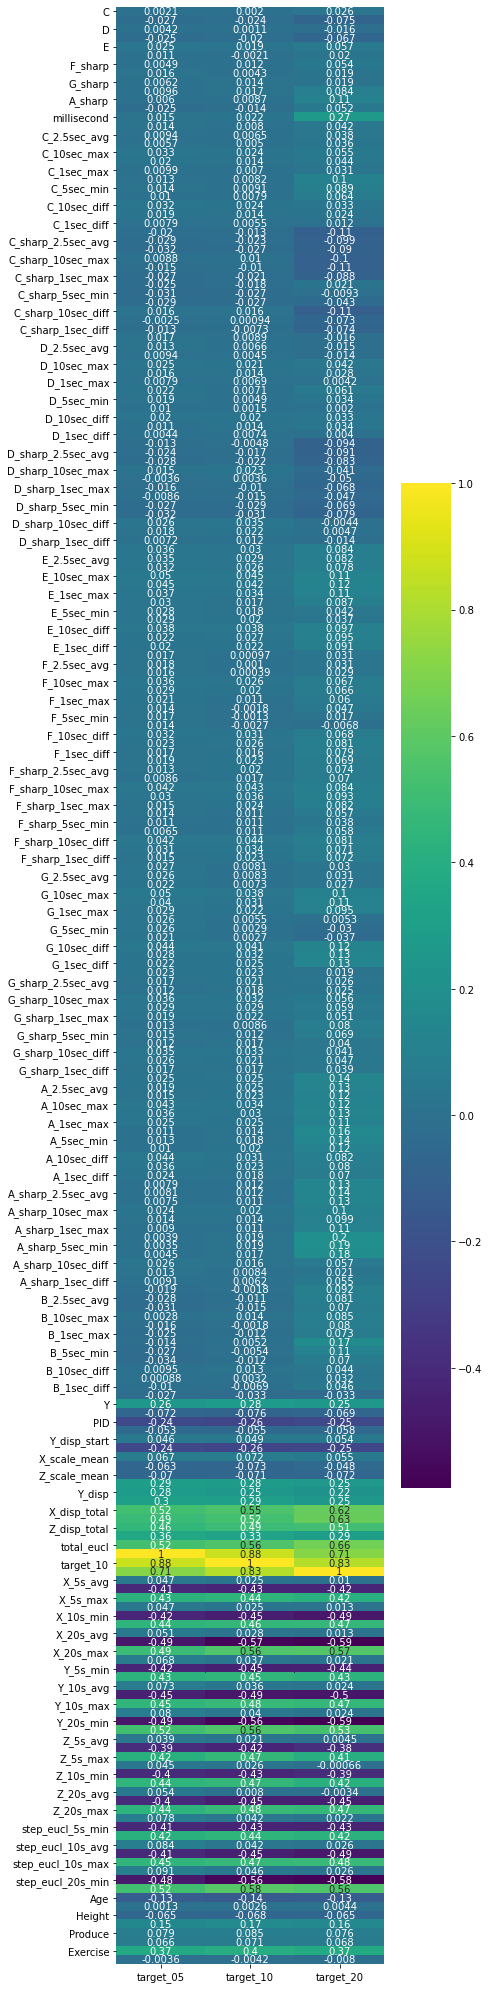

In [9]:
#Taking a look a correlations between features for non-silent only
music_data = model_data.loc[model_data['segment']!='silence']
corr_mus = music_data.corr()
plt.figure(figsize=(6,36))
with joblib.parallel_backend('dask'):
    sns.heatmap(corr_mus.loc[:,['target_05', 'target_10', 'target_20']], annot=True, cmap='viridis')
plt.show()

In [10]:
pca = PCA()
scaler = StandardScaler()

scaled = pd.DataFrame(scaler.fit_transform(model_data.drop(columns=['segment', 'SID', 'PID'])), 
                      columns=model_data.drop(columns=['segment', 'SID', 'PID']).columns)
pca.fit(scaled)

PCA()

In [11]:
ex = pca.explained_variance_ratio_

In [12]:
exdf = pd.DataFrame(ex.reshape(1, -1), columns =model_data.drop(columns=['segment', 'SID', 'PID']).columns )
exdf.T.rename(columns={0:'variance_explained'}).head(10)

,variance_explained
C,0.529037
C_sharp,0.075885
D,0.030363
D_sharp,0.028624
E,0.025924
F,0.019877
F_sharp,0.015268
G,0.014266
G_sharp,0.013044
A,0.012326


In [13]:
pca10 = PCA(n_components=10)
scaled = pd.DataFrame(scaler.fit_transform(model_data.drop(columns=['segment', 'SID', 'PID'])), 
                      columns=model_data.drop(columns=['segment', 'SID', 'PID']).columns)
model_pca = pca.fit_transform(scaled)

We can run an out of the box elasticNet on the PCA transformed model_data to see how it performs

In [14]:
elastic = ElasticNet()
#splits into ordered folds that can to allow for time series cross validation and reporting of scores
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_05', 20, 25)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
elastic.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

(0.41119398439316523, 7.7404494846925385)

Not very well. Let's try using the full dataset.

Much better. How about if we try 50 components with the PCA to get a middle ground of computation speed and results

In [15]:
pca50 = PCA(n_components=50)
elastic = ElasticNet()
#splits into ordered folds that can to allow for time series cross validation and reporting of scores
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_05', 20, 25)
X_train = pca50.fit_transform(X_train)
X_test = pca50.transform(X_test)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
elastic.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

(0.411193984474138, 7.740449483865412)

It would seem that using the whole dataset works best. Let's take a look at the predictions vs. actual when plotted

In [16]:
elastic_pred = pd.DataFrame(elastic.predict(X_test), columns=['Prediction'])
elastic_pred.insert(0, value=y_test, column='Actual')
elastic_pred

,Actual,Prediction
0,70.753370,66.154225
1,54.279927,50.299704
2,39.885464,49.687519
3,46.464013,48.510254
4,54.620693,64.221016
...,...,...
3457,50.872576,41.260960
3458,72.897084,68.856664
3459,53.936356,73.872713
3460,60.199130,51.575484


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

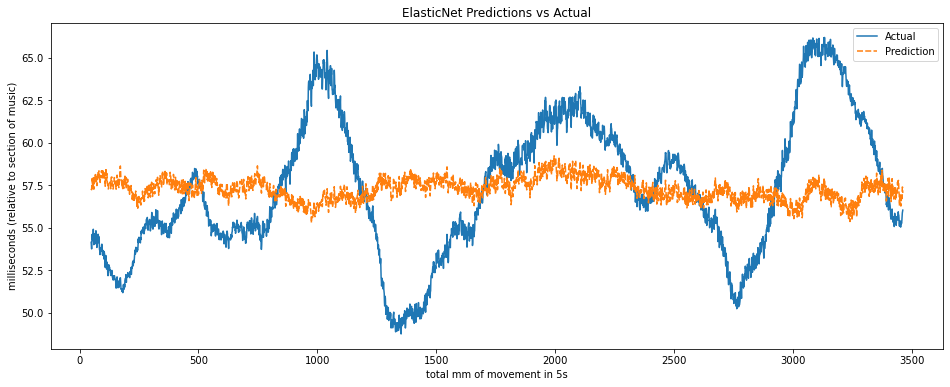

In [17]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=elastic_pred.rolling(50).mean())
plt.title('ElasticNet Predictions vs Actual')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

The predictions are at least in the right ballpark, but don't appear to follow the actual movment very well. We can try a RandomForest Regresor to see if it does any better.

In [18]:
rf = RandomForestRegressor()
#splits into ordered folds that can to allow for time series cross validation and reporting of scores
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_05', 20, 25)
with joblib.parallel_backend('dask'):
    rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

(0.08141138474024168, 9.266524321673518)

In [19]:
rf_pred = pd.DataFrame(y_pred, columns=['Prediction'])
rf_pred.insert(0, value=y_test, column='Actual')
rf_pred

,Actual,Prediction
0,70.753370,71.779973
1,54.279927,48.769223
2,39.885464,38.577523
3,46.464013,47.210892
4,54.620693,56.516382
...,...,...
3457,50.872576,54.057923
3458,72.897084,64.069585
3459,53.936356,73.026271
3460,60.199130,42.035680


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

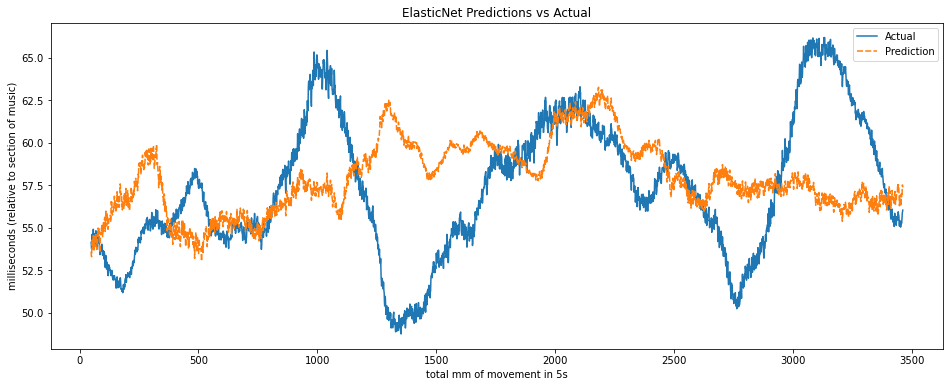

In [20]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=rf_pred.rolling(50).mean())
plt.title('ElasticNet Predictions vs Actual')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

The RandomForest seems to be more sensitve to the changes in the motion, but on average does a worse job with prediction. Let's try it for target_10 and target_20

## Target_10

In [21]:
elastic = ElasticNet()
#splits into ordered folds that can to allow for time series cross validation and reporting of scores
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_10', 40, 45)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
elastic.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316554.98348565213, tolerance: 306.1628702585658
  model = cd_fast.enet_coordinate_descent(


(0.31242903963031654, 15.420533335120703)

In [22]:
elastic_pred = pd.DataFrame(elastic.predict(X_test), columns=['Prediction'])
elastic_pred.insert(0, value=y_test, column='Actual')
elastic_pred

,Actual,Prediction
0,93.118995,82.719004
1,137.303673,99.949695
2,83.438641,89.460897
3,137.973681,100.389345
4,94.193666,82.533425
...,...,...
3357,74.379752,83.057818
3358,135.544512,137.936950
3359,77.865966,78.942888
3360,147.824838,162.109199


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

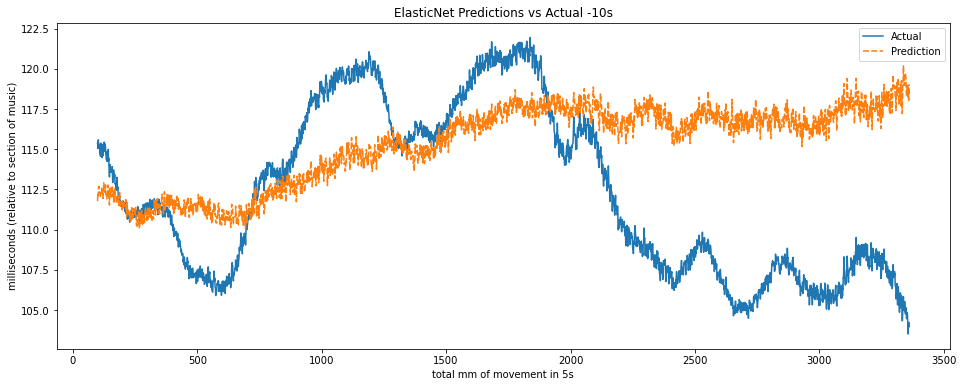

In [23]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=elastic_pred.rolling(100).mean())
plt.title('ElasticNet Predictions vs Actual -10s')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

The predictions are at least in the right ballpark, but don't appear to follow the actual movment very well. We can try a RandomForest Regresor to see if it does any better.

In [24]:
rf = RandomForestRegressor()
#splits into ordered folds that can to allow for time series cross validation and reporting of scores
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_10', 20, 25)
with joblib.parallel_backend('dask'):
    rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

(0.11163983257831067, 16.82961474259855)

In [25]:
rf_pred = pd.DataFrame(y_pred, columns=['Prediction'])
rf_pred.insert(0, value=y_test, column='Actual')
rf_pred

,Actual,Prediction
0,83.499876,83.612816
1,139.661177,139.282060
2,122.486802,125.472721
3,139.644109,139.237434
4,97.856936,97.881441
...,...,...
3357,136.662480,121.401756
3358,100.244984,95.180686
3359,108.260274,120.905837
3360,116.233744,93.503753


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

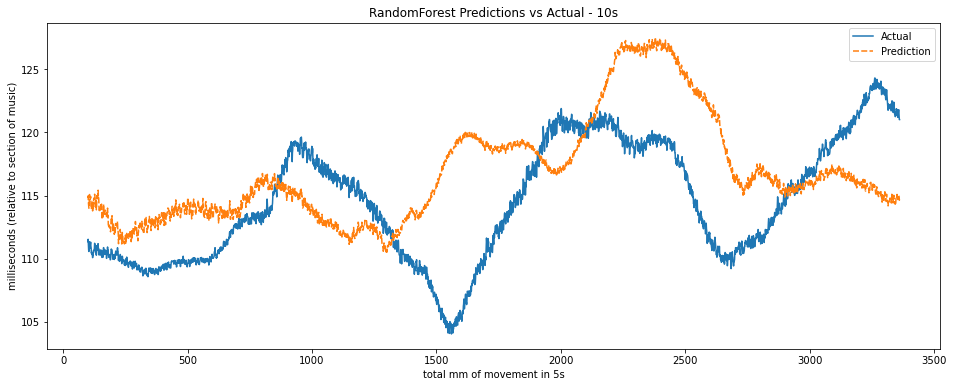

In [26]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=rf_pred.rolling(100).mean())
plt.title('RandomForest Predictions vs Actual - 10s')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

## Target_20

In [27]:
elastic = ElasticNet()
#splits into ordered folds that can to allow for time series cross validation and reporting of scores
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_20', 40, 45)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_test)
elastic.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 863469.5128289675, tolerance: 854.5374749562752
  model = cd_fast.enet_coordinate_descent(


(0.28623432980601504, 25.824203797290068)

In [28]:
elastic_pred = pd.DataFrame(elastic.predict(X_test), columns=['Prediction'])
elastic_pred.insert(0, value=y_test, column='Actual')
elastic_pred

,Actual,Prediction
0,219.379416,257.088212
1,264.429975,295.424924
2,182.820897,167.122211
3,231.804853,176.116044
4,265.875961,258.677138
...,...,...
3157,192.973580,310.932052
3158,172.599248,157.617944
3159,191.009568,173.372644
3160,273.450972,333.407527


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

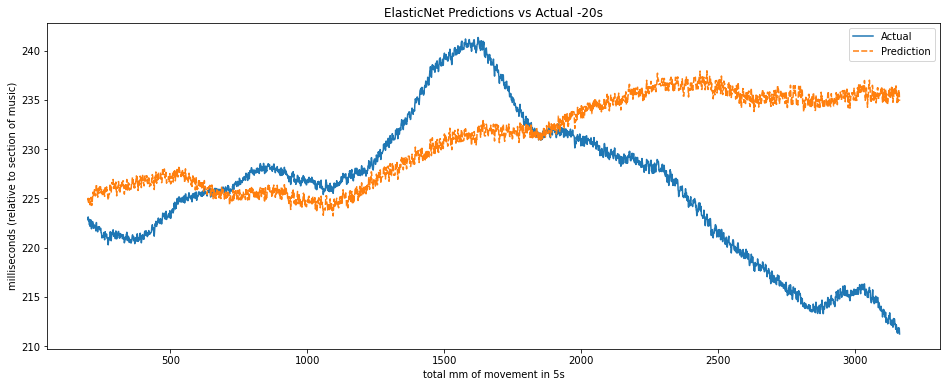

In [29]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=elastic_pred.rolling(200).mean())
plt.title('ElasticNet Predictions vs Actual -20s')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

The predictions are at least in the right ballpark, but don't appear to follow the actual movment very well. We can try a RandomForest Regresor to see if it does any better.

In [30]:
rf = RandomForestRegressor()
#splits into ordered folds that can to allow for time series cross validation and reporting of scores
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_20', 20, 25)
with joblib.parallel_backend('dask'):
    rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

(0.5565375209075532, 20.051975208844212)

In [31]:
rf_pred = pd.DataFrame(y_pred, columns=['Prediction'])
rf_pred.insert(0, value=y_test, column='Actual')
rf_pred

,Actual,Prediction
0,192.703070,193.431718
1,202.641993,204.737328
2,184.272687,188.051101
3,247.698150,252.785936
4,253.995476,254.994296
...,...,...
3157,229.428139,240.988829
3158,178.134753,211.029429
3159,218.093140,194.479974
3160,280.812631,243.382284


We will using the rolling mean of the predictions and actuals to make the visual more readible and allow us to see actual patterns over time.

[]

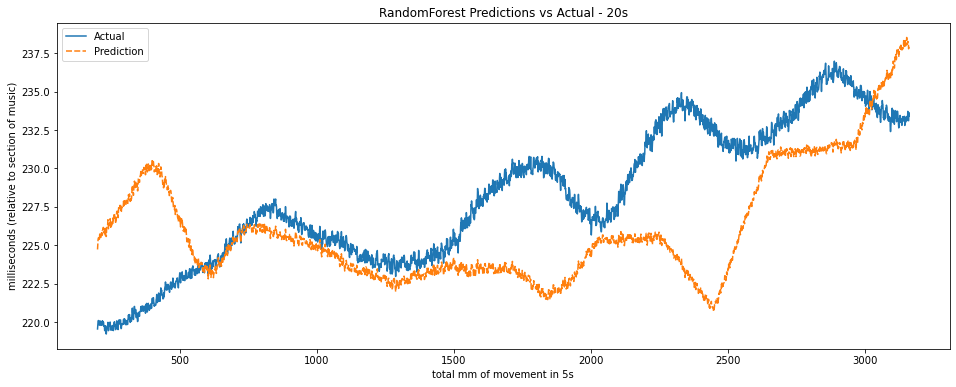

In [32]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=rf_pred.rolling(200).mean())
plt.title('RandomForest Predictions vs Actual - 20s')
plt.ylabel('milliseconds (relative to section of music)')
plt.xlabel('total mm of movement in 5s')
plt.plot()

From here we should move forward with RandomForest using Randomized Search to find better hyperparameters.